In [1]:
import os
import numpy as np
import torch
import itertools as it
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import scienceplots

In [2]:
def calculate_path_loss(r: float, f: float, G_t: float=10**1.5, G_r: float=10**0.5):
    '''
    description: 
    param {float} r: length of the central link
    param {float} f: carrier frequency
    param {float} G_t: transmit antenna gain
    param {float} G_r: receive antenna gain
    return {float} path_loss: a.k.a. channel gain
    '''
    wavelength = 3e8 * (1  / f)
    path_loss = ((wavelength / (4 * np.pi))**2) * (G_r * G_t / r**2)
    return path_loss

In [3]:
class ULA:
    def __init__(self, num_of_antennas: int, antenna_spacing: int, 
                 centre_coordinate: np.ndarray):
        '''
        description: 
        param {*} self
        param {int} num_of_antennas
        param {int} antenna_spacing
        param {np} centre_coordinate
        return {*}
        '''
        self.num_of_antennas = num_of_antennas
        self.centre_coordinate = centre_coordinate
        self.antenna_spacing = antenna_spacing
        self.aperture = antenna_spacing * (num_of_antennas - 1)
        self.element_coordinate = self._get_coordinate()

    def _get_coordinate(self):
        element_coordinate = np.vstack([np.linspace(-0.5 * (self.num_of_antennas - 1) * self.antenna_spacing,
                                                    0.5 * (self.num_of_antennas - 1) * self.antenna_spacing,
                                                    num=self.num_of_antennas, endpoint=True) + self.centre_coordinate[
                                            0],
                                        np.zeros(self.num_of_antennas) + self.centre_coordinate[1],
                                        np.zeros(self.num_of_antennas) + self.centre_coordinate[2]])
        return element_coordinate

In [4]:
def angular_transform(H: np.ndarray, ULA_BS: ULA, f=28e9):
    '''
    description: transform H from antenna space to angular space
    param {np.ndarray} H
    param {ULA} ULA_BS
    param {float} f: carrier freq (default as 28 GHz)
    return {tuple} H_a (angular domain channel), A (WTM), epsilon_arr (index)
    '''
    M = ULA_BS.num_of_antennas
    D = ULA_BS.aperture
    wave_length = 3e8 / f
    k = 2 * np.pi / wave_length
    epsilon_arr = np.arange(start=np.ceil(-D / wave_length), stop=np.floor(D / wave_length)+1, step=1, dtype=int)
    A = np.hstack([np.array(
        (1 / np.sqrt(M)) * np.exp(1j * ((2 * np.pi / D) * epsilon * ULA_BS.element_coordinate[0, :])), ndmin=2).T
                     for epsilon in epsilon_arr])
    H_a = A.T.conjugate() @ H @ A
    return H_a, A, epsilon_arr

In [5]:
def generate_nfc_los_channels(ULA_BS: ULA, target_coordinate: np.ndarray, f: float = 28e9):
    """
    Function: calculate NFC LoS channel matrix
    :param ULA_BS: ULA obj.
    :param f: float, carrier frequency
    :param target_coordinate: the position of the target.
    :return: H: nd.array in shape [ULA_Tx.num_of_antennas, ULA_Rx.num_of_antennas]
    """
    H = np.zeros((), dtype=np.complex64) # overall channel

    h = np.exp(-1j * (2 * np.pi / (3e8 / f)) * np.linalg.norm((ULA_BS.element_coordinate.T - 
                                                               target_coordinate), ord=2, axis=-1)).reshape(-1, 1)
    
    H = h @ h.transpose()

    return H

In [6]:
from multiprocessing import Pool

def generate_sample_helper(args):
    '''
    description: generates a single data point for the dataset.
    param {int} idx
    param {float} dist
    param {float} angle
    param {ULA} ULA_BS
    param {float} Carrier
    return {tuple} (label_xz, observation)
    '''
    idx, dist, angle, ULA_BS, f = args
    x = dist * np.cos(angle)
    z = dist * np.sin(angle)
    target_coordinate = np.array([x, 0.0, z])
    H = generate_nfc_los_channels(ULA_BS=ULA_BS, target_coordinate=target_coordinate, f=f)
    H_a, _, _ = angular_transform(H=H, ULA_BS=ULA_BS, f=f)
    observation = torch.from_numpy(np.abs(H_a @ np.ones((ULA_BS.num_of_antennas, 1)))).flatten().float()
    
    return (torch.tensor([x, z]), observation)



def generate_dataset_for_CNN(dist_arr: np.ndarray, angle_arr: np.ndarray, ULA_BS: ULA, 
                             f:float, num_of_processes: int, dataset_path: str='./samples/'):
    '''
    description: generate dataset for training CNN (or DNN)
    param {np.ndarray} dist_arr
    param {np.ndarray} angle_arr
    param {ULA} ULA_BS: ULA 
    param {float} f: carrier freq
    param {int} num_of_processes: number of processes
    param {str} dataset_path: where the dataset is saved.
    return {*}
    '''
    os.makedirs(dataset_path, exist_ok=True)
    label_polar_arr = np.array(list(it.product(dist_arr, angle_arr)))
    args_list = [(idx, dist, angle, ULA_BS, f) for idx, (dist, angle) in enumerate(label_polar_arr)]
    with Pool(processes=num_of_processes) as pool:
        results = list(tqdm(pool.imap(generate_sample_helper, args_list), 
                            total=len(args_list), desc='Generating data'))
    
    label_xz_arr, observation_arr = zip(*results)
    label_xz_arr = torch.stack(label_xz_arr)
    observation_arr = torch.stack(observation_arr)
    dataset_path = os.path.join(dataset_path, f'CNN-{int(ULA_BS.num_of_antennas)}')
    os.makedirs(dataset_path, exist_ok=True)
    torch.save(label_xz_arr, os.path.join(dataset_path, 'label.pth'))
    torch.save(observation_arr, os.path.join(dataset_path, 'observation_origi_arr.pth'))

In [7]:
def plot_projection(angle_list: np.ndarray, dist_list: np.ndarray, ULA_BS: ULA, f: float):
    '''
    description: plot received pilots (observation vector) in the noise-less environment
    param {np.ndarray} angle_list: an array containing all the angles
    param {np} dist_list: an array containing all the distances
    param {ULA} ULA_BS: ULA obj at the BS
    param {float} f: carrier freq.
    return {*}
    '''
    label_list = []
    observation_list = []
    M = ULA_BS.num_of_antennas
    for dist in dist_list:
        for angle in angle_list:
            target_coordinate = np.array([dist * np.cos(angle), 0, dist * np.sin(angle)])
            H = generate_nfc_los_channels(ULA_BS=ULA_BS, target_coordinate=target_coordinate, f=f)
            _, A, _ = angular_transform(H=H, ULA_BS=ULA_BS, f=f)
            observation = np.abs(A.T.conjugate() @ H @ A @ np.ones((M, 1)))
            observation = (observation - np.amin(observation)) / (np.amax(observation) - np.min(observation))
            observation = torch.from_numpy(observation)
            observation = torch.where(observation>0.5, torch.tensor(1.0), torch.tensor(0.0))
            # To obtain the observation:
            observation_list.append(observation)
            label_list.append(f'{180 * angle / np.pi:4.0f} dec.')

    
    fig_path = './figs/'
    os.makedirs(fig_path, exist_ok=True)
    with plt.style.context(['science', 'no-latex']):
        fig, ax = plt.subplots(figsize=(4, 1.5))
        ax.plot(observation_list[0], 'o--', color='#DE582B', linewidth=0.8, markevery=1, markersize=2, label=label_list[0])
        ax.plot(observation_list[1], '^-', color='#1868B2', linewidth=0.8, markevery=1, markersize=2, label=label_list[1])
        ax.plot(observation_list[2], 's-.', color='#018A67', linewidth=0.8, markevery=1, markersize=2, label=label_list[2])
        ax.annotate(f'{180 * angle_list[0] / np.pi:4.0f} deg.', (110, 0.2), xytext=(-0.5, 0.3), 
                        arrowprops=dict(arrowstyle='->'))
        ax.annotate(f'{180 * angle_list[1] / np.pi:4.0f} deg.', (230, 0.2), xytext=(110, 0.3), 
                        arrowprops=dict(arrowstyle='->'))
        ax.annotate(f'{180 * angle_list[2] / np.pi:4.0f} deg.', (405, 0.2), xytext=(420, 0.3),
                        arrowprops=dict(arrowstyle='->'))
        ax.set_xlabel(r'Index of antennas', fontsize=11)
        ax.set_ylabel(r'Observation $\mathbf{o}$', fontsize=11)
        plt.savefig(os.path.join(fig_path, 'observation_dist_1.eps'))
        plt.show()
    
    with plt.style.context(['science', 'no-latex']):
        fig, ax = plt.subplots(figsize=(4, 1.5))
        ax.plot(observation_list[3], 'o--', color='#DE582B', linewidth=0.8, markevery=1, markersize=2, label=label_list[3])
        ax.plot(observation_list[4], '^-', color='#1868B2', linewidth=0.8, markevery=1, markersize=2, label=label_list[4])
        ax.plot(observation_list[5], 's-.', color='#018A67', linewidth=0.8, markevery=1, markersize=2, label=label_list[5])
        ax.annotate(f'{180 * angle_list[0] / np.pi:4.0f} deg.', (120, 0.2), 
                    xytext=(0, 0.3), arrowprops=dict(arrowstyle='->'))
        ax.annotate(f'{180 * angle_list[1] / np.pi:4.0f} deg.', (250, 0.2), 
                    xytext=(130, 0.3), arrowprops=dict(arrowstyle='->'))
        ax.annotate(f'{180 * angle_list[2] / np.pi:4.0f} deg.', (395, 0.2), 
                    xytext=(420, 0.3), arrowprops=dict(arrowstyle='->'))
        ax.set_xlabel(r'Index of antennas', fontsize=11)
        ax.set_ylabel(r'Observation $\mathbf{o}$', fontsize=11)
        
        plt.savefig(os.path.join(fig_path, 'observation_dist_2.eps'))
        plt.show()

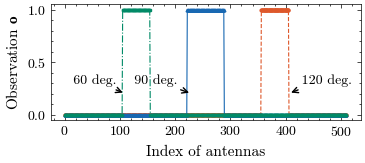

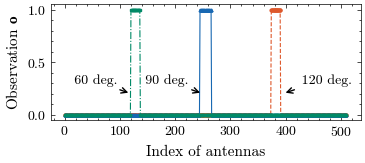

In [8]:
M = 511 # num of antennas
f = 28e9 # carrier freq. 28 GHz
wave_length = 3e8 / f # calculate wavelength
d = wave_length / 2 # half-wavelength antennas
ULA_BS = ULA(num_of_antennas=M, antenna_spacing=d, centre_coordinate=np.array([0, 0, 0]))

plot_projection(angle_list=[np.pi/3, np.pi/2, 2 * np.pi/3], dist_list=[10, 30], ULA_BS=ULA_BS, f=f)
#* generate training dataset for CNN
generate_dataset_for_CNN(dist_arr=np.arange(8, 35, step=0.01), angle_arr=np.arange(np.pi/4, 3* np.pi/4, step=0.01), ULA_BS=ULA_BS, num_of_processes=96,
                          f=f)

In [9]:
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import copy

class EchoSigDataset(Dataset):
    def __init__(self, bidirect:bool=True, dataset_path: str='./samples/CNN'):
        '''
        description: customized dataset for training neural networks
        param {*} self
        param {bool} bidirect: whether or not stack the original observation and the reversed observation on the channel dimension
        param {str} dataset_path: where the dataset is saved.
        return {*}
        '''
        self.label = torch.load(os.path.join(dataset_path, 'label.pth')).float()
        observation_origi_arr = torch.load(os.path.join(dataset_path, 'observation_origi_arr.pth'))
        observation_prime_arr = torch.flip(copy.deepcopy(observation_origi_arr), [1])
        if bidirect:
            # Here the MinMaxscalar is utilized:
            observation_origi_arr = (observation_origi_arr - torch.min(observation_origi_arr, dim=-1, keepdim=True)[0]) / (torch.max(observation_origi_arr, dim=-1, keepdim=True)[0] - torch.min(observation_origi_arr, dim=-1, keepdim=True)[0])
            observation_prime_arr = (observation_prime_arr - torch.min(observation_prime_arr, dim=-1, keepdim=True)[0]) / (torch.max(observation_prime_arr, dim=-1, keepdim=True)[0] - torch.min(observation_prime_arr, dim=-1, keepdim=True)[0])
            observation_origi_arr = torch.where(observation_origi_arr>0.5, torch.tensor(1.0), torch.tensor(0.0))
            observation_prime_arr = torch.where(observation_prime_arr>0.5, torch.tensor(1.0), torch.tensor(0.0))
            observation_origi_arr = observation_origi_arr.unsqueeze(1)
            observation_prime_arr = observation_prime_arr.unsqueeze(1)
            self.observation = torch.concat((observation_origi_arr, observation_prime_arr), dim=1).float()

        else:
            # Original data points:
            observation_origi_arr = (observation_origi_arr - torch.min(observation_origi_arr, dim=-1, keepdim=True)[0]) / (torch.max(observation_origi_arr, dim=-1, keepdim=True)[0] - torch.min(observation_origi_arr, dim=-1, keepdim=True)[0])
            observation_origi_arr = torch.where(observation_origi_arr>0.5, torch.tensor(1.0), torch.tensor(0.0))
            observation_origi_arr = observation_origi_arr.unsqueeze(1)
            self.observation = observation_origi_arr.float()

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.observation[idx], self.label[idx]

In [10]:
import torch.nn as nn
    
class BiCNN(nn.Module):
    '''
    description: NN architecture of the bi-direction CNN
    '''
    def __init__(self, out_dim: int, num_of_antenna: int=511):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size=2),
            nn.GELU(),
            nn.MaxPool1d(4),
            nn.Flatten()
            )
        
        if num_of_antenna == 511:
            self.dense_block = nn.Sequential(
                nn.Linear(1016,1024), 
                nn.GELU(),
                nn.Linear(1024, 1024),
                nn.GELU(),
                nn.Linear(1024, 512),
                nn.GELU()
                )
        else:
            self.dense_block = nn.Sequential(
                nn.Linear(504,1024), 
                nn.GELU(),
                nn.Linear(1024, 1024),
                nn.GELU(),
                nn.Linear(1024, 512),
                nn.GELU()
                )
        self.output_layer = nn.Sequential(
            nn.Linear(512, out_dim))

    def forward(self, observation: torch.Tensor):
        out = self.conv_block(observation)
        out = self.dense_block(out)
        out = self.output_layer(out)
        return out

class NaiveCNN(nn.Module):
    '''
    description: NN architecture of the naive CNN
    '''
    def __init__(self, out_dim: int, num_of_antenna: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=2),
            nn.GELU(),
            nn.MaxPool1d(4),
            nn.Flatten()
            )
        if num_of_antenna == 511:
            self.dense_block = nn.Sequential(
                nn.Linear(1016, 1024),
                nn.GELU(),
                nn.Linear(1024, 1024),
                nn.GELU(),
                nn.Linear(1024, 512),
                nn.GELU()
                )
        else:
            self.dense_block = nn.Sequential(
                nn.Linear(504, 1024),
                nn.GELU(),
                nn.Linear(1024, 1024),
                nn.GELU(),
                nn.Linear(1024, 512),
                nn.GELU()
                )
        self.output_layer = nn.Sequential(
            nn.Linear(512, out_dim))

    def forward(self, observation: torch.Tensor):
        out = self.conv_block(observation)
        out = self.dense_block(out)
        out = self.output_layer(out)
        return out

class NaiveDNN(nn.Module):
    '''
    description: NN architecture of the naive DNN
    '''
    def __init__(self, out_dim: int, num_of_antenna: int):
        super().__init__()
        if num_of_antenna == 511:
            self.dense_block = nn.Sequential(
                nn.Linear(511, 1016), # 511 for M=511
                nn.GELU(),
                nn.Linear(1016,1024),
                nn.GELU(),
                nn.Linear(1024, 1024),
                nn.GELU(),
                nn.Linear(1024, 512),
                nn.GELU()
                )
        else:
            self.dense_block = nn.Sequential(
                nn.Linear(255, 1016), # 511 for M=511
                nn.GELU(),
                nn.Linear(1016,1024),
                nn.GELU(),
                nn.Linear(1024, 1024),
                nn.GELU(),
                nn.Linear(1024, 512),
                nn.GELU()
                )
        self.output_layer = nn.Sequential(
            nn.Linear(512, out_dim))

    def forward(self, observation: torch.Tensor):
        observation = observation.squeeze(1) # pop out the channel dimension
        out = self.dense_block(observation)
        out = self.output_layer(out)
        return out

In [11]:
@torch.no_grad()
def sense_one_round(model, H: np.ndarray, A: np.ndarray, transmit_power: float, noise_power: float):
    '''
    description: sense via a snapshot for the proposed BiCNN method.
    param {*} model: pretrained NN
    param {np.ndarray} H: round-trip channel matrix  
    param {np.ndarray} A: wavenumber-domain transformation matrix
    param {float} transmit_power
    param {float} noise_power
    return {np.ndarray} preds: the estimated position of the target.
    '''
    M = H.shape[0]
    # To obtain the Rx observation:
    # 1. transmit two DL pilots
    noise = np.sqrt(0.5 * noise_power) * np.random.normal(0, 1, (M, 1)) + 1j * np.sqrt(0.5 * noise_power) * np.random.normal(0, 1, (M, 1))
    beamformer = np.sqrt(transmit_power) * (A @  np.ones((M, 1))) / np.linalg.norm((A @  np.ones((M, 1))).flatten(), ord=2)
    observation = A.T.conjugate() @ (H @ beamformer + noise)
    # 2. normalize the received pilots:
    observation = np.abs(observation)
    # 3. feed the normalized pilots to pre-trained NN:
    observation = torch.from_numpy(observation).float().flatten()
    observation = (observation - torch.min(observation)) / (torch.max(observation) - torch.min(observation))
    observation = torch.where(observation>0.5, torch.tensor(1.0), torch.tensor(0.0))
    observation_prime = torch.flip(copy.deepcopy(observation), [-1])
    observation = torch.concat((observation.view(1, 1, -1), observation_prime.view(1, 1, -1)), dim=1)
    model = model.cpu() 
    preds = model(observation)

    return preds.cpu().numpy()

In [12]:
def train_model(model, model_name, train_loader, valid_loader, optimizer, lr_scheduler, criterion, max_epcoh, device, patience=7, 
                overwrite=False, model_path='./saved_model', data_path='./saved_data/train'):
    '''
    description: The training function of the model
    param {*} model: randomly-initialized model
    param {str} model_name: model name
    param {*} train_loader: dataloader for training dataset
    param {*} valid_loader: dataloader for training dataset
    param {*} optimizer
    param {*} lr_scheduler: schedule the learning rate.
    param {*} criterion: the loss function.
    param {int} max_epcoh: the maximum epoch needs to be run.
    param {*} device: where the model will be trained.
    param {int} patience: if the validating score have no improvement within ``patience" epochs, 
                            the training process will be stopped.
    param {*} overwrite: if True, a new model will be trained; otherwise, the pre-trained model will be loaded.
    param {str} model_path: where the params of model is saved at.
    param {str} data_path: where the training process results are saved at.
    return {*}
    '''
    if overwrite:
        print(f'\t (The model will be re-trained...)')
        os.makedirs(model_path, exist_ok=True)
        os.makedirs(data_path, exist_ok=True)
        best_val_epoch = -1
        valid_loss_list = []
        train_loss_list = []
        model.train()
        for epoch in range(max_epcoh):
            train_loss = 0.0
            count = 0
            t = tqdm(train_loader, leave=False)
            for (observation, label) in t: 
                observation= observation.to(device)
                label = label.to(device)
                preds = model(observation)
                loss = criterion(preds, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.detach().cpu().item()
                count += 1
                t.set_description(f'Epoch {epoch}: loss={loss.item():4.2f}')
            lr_scheduler.step()
            valid_loss = validate_model(model, valid_loader, criterion, device=device)
            train_loss_list.append(train_loss / count) 
            valid_loss_list.append(valid_loss)
            print(f'Epoch {epoch}: training loss: {train_loss_list[epoch]:4.2f}, validation loss: {valid_loss_list[epoch]:4.2f}')

            np.save(os.path.join(data_path, f'{model.__class__.__name__}_train_loss.npy'), np.array(train_loss_list))
            np.save(os.path.join(data_path, f'{model.__class__.__name__}_valid_loss.npy'), np.array(valid_loss_list))
            if len(valid_loss_list) == 1 or valid_loss < valid_loss_list[best_val_epoch]:
                print(f'\t (New best performance, saving model at epoch {epoch})')
                torch.save(model.state_dict(), os.path.join(model_path, model_name))
                best_val_epoch = epoch
            elif best_val_epoch  <= epoch - patience:
                print(f'\t (Early stop due the no improvements over the last {patience} epoch)')
                return model
    else:
        print(f'\t (The model will be loaded...)')
        checkpoint = torch.load(os.path.join(model_path, model_name))
        model.load_state_dict(checkpoint)
        return model 

def validate_model(model, valid_loader, criterion, device):
    '''
    description: validate the model on the validating set
    param {*} model
    param {*} valid_loader
    param {*} criterion
    param {*} device
    return {*}
    '''
    model.eval()
    avg_loss = []
    for observation, label in valid_loader: 
        observation = observation.to(device)
        label = label.to(device)
        with torch.no_grad():
            preds = model(observation)
            loss = criterion(preds, label)
            avg_loss.append(loss.cpu().item())
    return sum(avg_loss) / len(avg_loss)

def test_model_on_real_system(model, ULA_BS: ULA, target_dist_arr: np.ndarray, 
                              target_angle_arr: np.ndarray, transmit_power_arr: np.ndarray, 
                              noise_power: float, f:float, monte_carlo_times=10, fig_path='./figs/'):
    '''
    description: the pre-trained model will be tested on real environment (pathloss and noise are included.)
                 all the possible combinations of target_dist_arr and target_angle_arr
    param {*} model: pre-trained model
    param {ULA} ULA_BS: ULA obj. at the BS
    param {np} target_dist_arr: the distance array of the target
    param {np} target_angle_arr: the angle array of the target
    param {float} transmit_power
    param {float} noise_power
    param {float} f: carrier frequency
    param {*} data_path: where the results are saved at
    return {*}
    '''
    label_list = []
    preds_pow_1_list = []
    preds_pow_2_list = []
    for dist in target_dist_arr:
        for angle in target_angle_arr:
            target_coordinate = np.array([dist * np.cos(angle), 0, dist * np.sin(angle)])
            H = generate_nfc_los_channels(ULA_BS=ULA_BS, target_coordinate=target_coordinate, f=f)
            _, A, _ = angular_transform(H=H, ULA_BS=ULA_BS, f=f)
            path_loss = calculate_path_loss(r=2 * dist, f=f)
            H = np.sqrt(path_loss) * H
            preds = np.zeros((monte_carlo_times, 2))
            for it in range(monte_carlo_times):
                preds[it] = sense_one_round(model, H, A, transmit_power_arr[0], noise_power)
            preds = np.mean(preds, axis=0)
            label_list.append(target_coordinate)
            preds_pow_1_list.append(preds)
    
    for dist in target_dist_arr:
        for angle in target_angle_arr:
            target_coordinate = np.array([dist * np.cos(angle), 0, dist * np.sin(angle)])
            H = generate_nfc_los_channels(ULA_BS=ULA_BS, target_coordinate=target_coordinate, f=f)
            _, A, _ = angular_transform(H=H, ULA_BS=ULA_BS, f=f)
            path_loss = calculate_path_loss(r=2 * dist, f=f)
            H = np.sqrt(path_loss) * H
            preds = np.zeros((monte_carlo_times, 2))
            for it in range(monte_carlo_times):
                preds[it] = sense_one_round(model, H, A, transmit_power_arr[1], noise_power)
            preds = np.mean(preds, axis=0)
            label_list.append(target_coordinate)
            preds_pow_2_list.append(preds)
            
    label_arr = np.array(label_list)
    preds_pow_1_arr = np.array(preds_pow_1_list)  
    preds_pow_2_arr = np.array(preds_pow_2_list)  
    with plt.style.context(['science', 'no-latex']):
        fig, ax = plt.subplots(figsize=(2.4 * 1.618, 2.4)) 
        # ax.plot_trisurf  
        ax.scatter(label_arr[:, 0], label_arr[:, -1], color='red', facecolors='none', 
                   marker='s', s=10, label="Ground Truth") 
        ax.scatter(preds_pow_1_arr[:, 0], preds_pow_1_arr[:, -1], color='blue', facecolors='none',  
                   marker='o', s=10, label=f"BiCNN, {int(10 * np.log10(transmit_power_arr[0] * 1e3))} dBm")
        ax.scatter(preds_pow_2_arr[:, 0], preds_pow_2_arr[:, -1], color='darkorange', facecolors='none',  
                   marker='d', s=10, label=f"BiCNN, {int(10 * np.log10(transmit_power_arr[1] * 1e3))} dBm")
        ax.set_xlabel(r'$x$ coordinates', fontsize=11.5)
        ax.set_ylabel(r'$z$ coordinates', fontsize=11.5)
        ax.legend(fontsize=9, frameon=True)
        os.makedirs(fig_path, exist_ok=True)
        plt.savefig(os.path.join(fig_path, 'test_nn.eps'))
        plt.show()

In [13]:
def compare_diff_nn_struct(num_of_antenna: int, data_path='./saved_data/'):
    '''
    description: in this implementation, we compare different NN architectures 
    to fortify the superiority of the proposed method
    '''
    bi_echo_signal_dataset = EchoSigDataset(bidirect=True, dataset_path=f'./samples/CNN-{num_of_antenna}')
    mo_echo_signal_dataset = EchoSigDataset(bidirect=False, dataset_path=f'./samples/CNN-{num_of_antenna}')
    total_count = len(bi_echo_signal_dataset)
    train_count = int(0.7 * total_count)
    valid_count = int(0.2 * total_count)
    test_count = total_count - train_count - valid_count
    train_bi_dataset, valid_bi_dataset, test_bi_dataset = torch.utils.data.random_split(
        bi_echo_signal_dataset, (train_count, valid_count, test_count)
    )
    train_mo_dataset, valid_mo_dataset, test_mo_dataset = torch.utils.data.random_split(
        mo_echo_signal_dataset, (train_count, valid_count, test_count)
    )
    train_bi_loader = DataLoader(train_bi_dataset, batch_size=128)
    valid_bi_loader = DataLoader(valid_bi_dataset, batch_size=32)
    train_mo_loader = DataLoader(train_mo_dataset, batch_size=128)
    valid_mo_loader = DataLoader(valid_mo_dataset, batch_size=32)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Training using {device}')
    model_list = []
    model_list.append(BiCNN(out_dim=2, num_of_antenna=num_of_antenna).to(device))
    model_list.append(NaiveCNN(out_dim=2, num_of_antenna=num_of_antenna).to(device))
    model_list.append(NaiveDNN(out_dim=2, num_of_antenna=num_of_antenna).to(device))
    number_learnable_params_dict = dict()
    for model in model_list:
        print(f'Train {model.__class__.__name__}:')
        num_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Number of trainable params: {num_learnable_params}')
        number_learnable_params_dict[model.__class__.__name__] = num_learnable_params
        if model.__class__.__name__ == 'BiCNN':
            train_loader = train_bi_loader
            valid_loader = valid_bi_loader
        else:
            train_loader = train_mo_loader
            valid_loader = valid_mo_loader
        criterion = nn.HuberLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
        model = train_model(model=model, model_name=model.__class__.__name__, train_loader=train_loader, 
            valid_loader=valid_loader, optimizer=optimizer, 
            lr_scheduler=scheduler, criterion=criterion, 
            patience=10, max_epcoh=10, overwrite=True, device=device, 
            model_path=f'./saved_model/CNN-{num_of_antenna}', 
            data_path=f'./saved_data/CNN-{num_of_antenna}')
    data_path = os.path.join(data_path, f'CNN-{num_of_antenna}')
    os.makedirs(data_path, exist_ok=True)
    np.save(os.path.join(data_path, 'number_of_param_dict.npy'), number_learnable_params_dict)
        

from matplotlib.patches import Ellipse

def plot_compare_diff_nn_struct(num_of_antenna: int, data_path='./saved_data/', fig_path='./figs/'):
    '''
    description: this is an associated function for plot the results of ``compare_diff_nn_struct()"
    '''
    data_path = os.path.join(data_path, f'CNN-{num_of_antenna}')
    BiCNN_train_loss = np.load(os.path.join(data_path, 'BiCNN_train_loss.npy'))
    NaiveCNN_train_loss = np.load(os.path.join(data_path, 'NaiveCNN_train_loss.npy'))
    NaiveDNN_train_loss = np.load(os.path.join(data_path, 'NaiveDNN_train_loss.npy'))
    number_of_param_dict = np.load(os.path.join(data_path, 'number_of_param_dict.npy'), allow_pickle=True)

    with plt.style.context(['science', 'no-latex']):
        fig, ax = plt.subplots(figsize=(2.4 * 1.618, 2.4))
        
        ax.plot(BiCNN_train_loss, color='blue', marker='o', ls='-', linewidth=0.8, 
                markevery=1, markerfacecolor="None", 
                label=f"BiCNN, RC={number_of_param_dict.item().get('BiCNN') / number_of_param_dict.item().get('NaiveDNN'): 3.2f}")
        
        ax.plot(NaiveCNN_train_loss, color='darkorange', marker='^', ls='-.', linewidth=0.8, 
                markevery=1, markerfacecolor="None", 
                label=f"Traditional CNN, RC={number_of_param_dict.item().get('NaiveCNN') / number_of_param_dict.item().get('NaiveDNN'): 3.2f}")
        
        ax.plot(NaiveDNN_train_loss, color='darkviolet', marker='d', ls='--', linewidth=0.8, 
                markevery=1, markerfacecolor="None", 
                label=f"Traditional DNN, RC={number_of_param_dict.item().get('NaiveDNN') / number_of_param_dict.item().get('NaiveDNN'): 3.2f}")
        
        ax.set_xlabel(r'Index of Epoch', fontsize=10.5)
        ax.set_ylabel(r'Averaged Huber Loss', fontsize=10.5)
        ax.legend(fontsize=9, frameon=True)
        os.makedirs(data_path, exist_ok=True)
        plt.savefig(os.path.join(fig_path, 'comparison_between_nn.eps'))
        plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


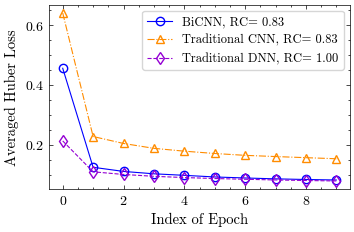

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


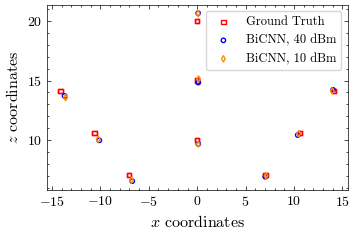

In [14]:
np.random.seed(123) # seed for replicable
# compare_diff_nn_struct(num_of_antenna=M)
plot_compare_diff_nn_struct(num_of_antenna=M, data_path=f'./saved_data/')
model = BiCNN(out_dim=2, num_of_antenna=M)
checkpoint = torch.load(os.path.join(f'./saved_model/CNN-{M}', 'BiCNN'))
model.load_state_dict(checkpoint)
test_model_on_real_system(model=model, ULA_BS=ULA_BS, 
                          target_dist_arr=[10, 15, 20], 
                          target_angle_arr=[np.pi/4, np.pi/2, 3* np.pi/4-1e-8], 
                          transmit_power_arr=np.array([10, 0.01]), noise_power=10**(-10.5), 
                          f=f, monte_carlo_times=100) # -174 dBm/Hz with 10 kHz bandwidth

In [15]:
def music_algorithm(observation: np.ndarray, ULA_BS: ULA, dist_range: list, 
                    angle_range: list, num_of_grid: int, visualization: bool=False):
    '''
    description: an implementation of MUSIC algorithm for 2D grids
    param {np} observation: received observation vector (without any processing)
    param {ULA} ULA_BS: ULA at the BS
    param {list} dist_range: distance range
    param {list} angle_range: angle range
    param {int} num_of_grid: total number of grids in Cartesian coordinate
    param {bool} visualization: whether or not to visualize the 2D MUISC spectrum.
    return {*}
    '''
    R = observation @ observation.conj().T
    eigenvalues, eigenvectors = np.linalg.eig(R) # eigenvalue decomposition
    idx = eigenvalues.argsort()[::-1] # descending order
    sorted_eigenvalues = eigenvalues[idx]
    sorted_eigenvectors = eigenvectors[:, idx]
    D_s = sorted_eigenvalues[0]
    E_s = sorted_eigenvectors[:, 0]
    E_n = sorted_eigenvectors[:, 1:]
    U = E_n @ E_n.conj().T 
    if not visualization:
        # for a fair comparison with the NN method, we only sample the grids in the region where the training data is generated.
        dist_arr=np.linspace(dist_range[0], dist_range[1], num=int(np.sqrt(num_of_grid))) 
        angle_arr=np.linspace(angle_range[0], angle_range[1], num=int(np.sqrt(num_of_grid)))
        proj_min = 10e3
        target_position = np.zeros(2)
        for dist in dist_arr:
            for angle in angle_arr:
                target_coordinate = np.array([dist * np.cos(angle), 0, dist * np.sin(angle)])
                a = np.exp(-1j * (2 * np.pi / (3e8 / f)) * np.linalg.norm((ULA_BS.element_coordinate.T - target_coordinate), 
                                                                        ord=2, axis=-1)).reshape(-1, 1)
                proj = np.real(a.conj().T @ U @ a)
                if proj < proj_min:
                    proj_min = proj
                    target_position[0] = dist * np.cos(angle)
                    target_position[1] = dist * np.sin(angle)
        return target_position
    else:
        # for a fair comparison with the NN method, we only sample the grids in the region where the training data is generated.
        dist_arr=np.linspace(dist_range[0], dist_range[1], num=num_of_grid) 
        angle_arr=np.linspace(angle_range[0], angle_range[1], num=num_of_grid)
        spectrum = np.zeros((dist_arr.shape[0], angle_arr.shape[0]))
        proj_min = 10e3
        target_position = np.zeros(2)
        for dist_idx, dist in enumerate(dist_arr):
            for angle_idx, angle in enumerate(angle_arr):
                target_coordinate = np.array([dist * np.cos(angle), 0, dist * np.sin(angle)])
                a = np.exp(-1j * (2 * np.pi / (3e8 / f)) * np.linalg.norm((ULA_BS.element_coordinate.T - target_coordinate), 
                                                                        ord=2, axis=-1)).reshape(-1, 1)
                proj = np.real(a.conj().T @ U @ a)
                spectrum[dist_idx, angle_idx] = proj
                if proj < proj_min:
                    proj_min = proj
                    target_position[0] = dist * np.cos(angle)
                    target_position[1] = dist * np.sin(angle)
        return spectrum, target_position

def sense_one_round_music(ULA_BS: ULA, H: np.ndarray, A: np.ndarray, dist_range: list, 
                    angle_range: list, transmit_power: float, noise_power: float, num_of_grid: int,
                    visualization: bool=False):
    '''
    description: sensing via one snapshot using the MUSIC algorithm
    param {ULA} ULA_BS: ULA obj. at the BS
    param {np.ndarray} H: round-trip channel matrix 
    param {np.ndarray} A: WTM 
    param {float} transmit_power
    param {float} noise_power
    param {int} num_of_grid
    return {np.ndarray} the estimated position of the target.
    '''
    M = H.shape[0]
    # To obtain the Rx observation:
    # 1. transmit two DL pilots
    noise = np.sqrt(0.5 * noise_power) * np.random.normal(0, 1, (M, 1)) + 1j * np.sqrt(0.5 * noise_power) * np.random.normal(0, 1, (M, 1))
    beamformer = np.sqrt(transmit_power) * (A @  np.ones((M, 1))) / np.linalg.norm((A @  np.ones((M, 1))).flatten(), ord=2)
    observation = H @ beamformer + noise
    res = music_algorithm(observation=observation, ULA_BS=ULA_BS, dist_range=dist_range, 
                          angle_range=angle_range, num_of_grid=num_of_grid, 
                          visualization=visualization)
    if not visualization:
        target_position = res
        return target_position
    else:
        spectrum, target_position = res
        return spectrum, target_position

Estimated x -9.87011599917972 and y 17.325692337878262       
Ground Truth dist -9.878580214255274 and angle 17.39004465061905


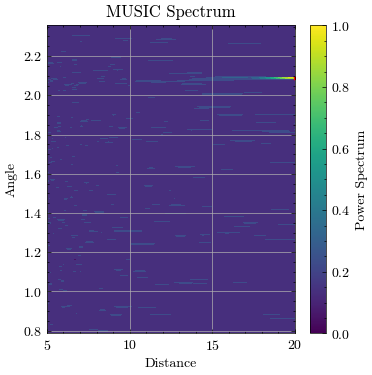

In [16]:
# here we add a function to verify the implementation of MUSIC:
M = 511 # num of antennas
f = 28e9 # carrier freq. 28 GHz
wave_length = 3e8 / f # calculate wavelength
d = wave_length / 2 # half-wavelength antennas
ULA_BS = ULA(num_of_antennas=M, antenna_spacing=d, centre_coordinate=np.array([0, 0, 0]))
transmit_power = 10
noise_power = 10**(-10.5)
# 2.087399541969217, dist 20
dist = 20
angle = 2.087399
angle_range = [np.pi/4, 3 * np.pi/4]
dist_range = [5, 20]
num_of_grid = 500
target_coordinate = np.array([dist * np.cos(angle), 0, dist * np.sin(angle)])
H = generate_nfc_los_channels(ULA_BS=ULA_BS, target_coordinate=target_coordinate, f=f)
_, A, _ = angular_transform(H=H, ULA_BS=ULA_BS, f=f)
path_loss = calculate_path_loss(r=2 * dist, f=f)
H = np.sqrt(path_loss) * H
spectrum, target_position = sense_one_round_music(ULA_BS=ULA_BS, H=H, A=A, transmit_power=transmit_power, 
                                 noise_power=noise_power, 
                                 dist_range=dist_range, angle_range=angle_range, 
                                 num_of_grid=num_of_grid, visualization=True)
print(f'Estimated x {target_position[0]} and y {target_position[1]} \
      \nGround Truth dist {target_coordinate[0]} and angle {target_coordinate[-1]}')
dist_arr=np.linspace(dist_range[0], dist_range[1], num=num_of_grid) 
angle_arr=np.linspace(angle_range[0], angle_range[1], num=num_of_grid)
with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(4, 4))
    plt.contourf(dist_arr, angle_arr, 1/spectrum.T, 
                 levels=10, 
                 cmap='viridis')
    plt.scatter(dist, angle, color='red', marker='x', s=5)
    plt.colorbar(label='Power Spectrum')
    plt.title('MUSIC Spectrum')
    plt.xlabel('Distance')
    plt.ylabel('Angle')
    plt.grid(True)
    plt.show()

In [17]:
import time 
import json

def test_model_and_benchmark_on_real_system(model, ULA_BS: ULA, target_dist_arr: np.ndarray, 
                                            target_angle_arr: np.ndarray, dist_range: list, 
                                            angle_range: list, transmit_power: float, 
                                            noise_power: float, f:float, num_of_grid_arr: np.ndarray, 
                                            data_path='./figs'):
    '''
    description: in this function, we compares the NN method with the MUSIC algorithm with the presence of noise and pathloss, 
                 in terms of accuracy and running time.
    param {*} model: pretrained NN
    param {ULA} ULA_BS: ULA obj. at the BS
    param {np} target_dist_arr
    param {np} target_angle_arr
    param {float} transmit_power
    param {float} noise_power
    param {float} f: carrier frequency
    param {np} num_of_grid_arr: the number of grids in the stepup of the MUSIC algorithm. 
    param {*} monte_carlo_times: number of Monte Carlo simulation 
    param {*} data_path
    return {dict}: dictionary contains the simulation results.
    '''
    compare_result_dict = dict()
    bicnn_rse_error_list = []
    bicnn_run_time_list = []
    for dist in target_dist_arr:
        for angle in target_angle_arr:
            ULA_BS = ULA(num_of_antennas=M, antenna_spacing=d, centre_coordinate=np.array([0, 0, 0]))
            target_coordinate = np.array([dist * np.cos(angle), 0, dist * np.sin(angle)])
            H = generate_nfc_los_channels(ULA_BS=ULA_BS, target_coordinate=target_coordinate, f=f)
            _, A, _ = angular_transform(H=H, ULA_BS=ULA_BS, f=f)
            path_loss = calculate_path_loss(r=2 * dist, f=f)
            H = np.sqrt(path_loss) * H
            # BiCNN method: 
            time_start = time.time()
            preds= sense_one_round(model, H, A, transmit_power, noise_power).squeeze(0)
            time_end = time.time()
            bicnn_rse_error_list.append(np.sqrt(0.5 * (preds[0] - target_coordinate[0])**2 + 
                                                0.5 * (preds[1] - target_coordinate[-1])**2))
            bicnn_run_time_list.append(time_end-time_start)
    
    compare_result_dict['BiCNN RMSE'] = np.round(np.mean(bicnn_rse_error_list), decimals=5)
    compare_result_dict['BiCNN Avg. Run Time'] = np.round(np.mean(bicnn_run_time_list), decimals=5)

    for num_of_grid in num_of_grid_arr:
        music_rse_error_list = []
        music_run_time_list = []
        for dist in target_dist_arr:
            for angle in target_angle_arr:
                ULA_BS = ULA(num_of_antennas=M, antenna_spacing=d, centre_coordinate=np.array([0, 0, 0]))
                target_coordinate = np.array([dist * np.cos(angle), 0, dist * np.sin(angle)])
                H = generate_nfc_los_channels(ULA_BS=ULA_BS, target_coordinate=target_coordinate, f=f)
                _, A, _ = angular_transform(H=H, ULA_BS=ULA_BS, f=f)
                path_loss = calculate_path_loss(r=2 * dist, f=f)
                H = np.sqrt(path_loss) * H
                # MUSIC method
                time_start = time.time()
                spectrum, target_position_est = sense_one_round_music(ULA_BS=ULA_BS, H=H, A=A, transmit_power=transmit_power, 
                                                noise_power=noise_power, num_of_grid=num_of_grid, 
                                                angle_range=angle_range, dist_range=dist_range, 
                                                visualization=True)

                time_end = time.time()
                music_rse_error_list.append(np.sqrt(0.5 * (target_position_est[0] - target_coordinate[0])**2 + 
                                                0.5 * (target_position_est[1] - target_coordinate[-1])**2))
                music_run_time_list.append(time_end-time_start)
        compare_result_dict[f'MUSIC RMSE with Gird {num_of_grid**2}'] = np.round(np.mean(music_rse_error_list), decimals=5)
        compare_result_dict[f'MUSIC Avg. Run Time with Grid {num_of_grid**2}'] = np.round(np.mean(music_run_time_list), decimals=5)
    
    path = os.path.join(data_path, 'comparison_with_music.json')
    with open(path, 'w') as f:
        json.dump(compare_result_dict, f)
    return compare_result_dict

def test_model_and_benchmark_dist_antenna_array(target_dist_arr: np.ndarray, target_angle_arr: np.ndarray,
                                                 transmit_power: float, aperture_arr: list,
                                                 noise_power: float, f:float, num_of_grid: int, 
                                                 dist_range: list, angle_range: list, 
                                                 data_path='./figs'):
    '''
    description: in this function, we compares the NN method with the MUSIC algorithm with the presence of noise and pathloss, 
                 in terms of accuracy and running time (distance and aperture size).
    param {np} target_dist_arr
    param {np} target_angle_arr
    param {float} transmit_power
    param {float} noise_power
    param {float} f: carrier frequency
    param {np} num_of_grid_arr: the number of grids in the stepup of the MUSIC algorithm. 
    param {*} monte_carlo_times: number of Monte Carlo simulation 
    param {*} data_path
    return {dict}: dictionary contains the simulation results.
    '''
    BiCNN_res = dict()
    MUSIC_res = dict()
    for M in aperture_arr:
        ULA_BS = ULA(num_of_antennas=M, antenna_spacing=d, centre_coordinate=np.array([0, 0, 0]))
        model = BiCNN(out_dim=2, num_of_antenna=M)
        checkpoint = torch.load(os.path.join(f'./saved_model/CNN-{M}', 'BiCNN'))    
        model.load_state_dict(checkpoint)
        bicnn_rse_error_list = []
        bicnn_run_time_list = []
        for dist in target_dist_arr:
            for angle in target_angle_arr:
                ULA_BS = ULA(num_of_antennas=M, antenna_spacing=d, centre_coordinate=np.array([0, 0, 0]))
                target_coordinate = np.array([dist * np.cos(angle), 0.0, dist * np.sin(angle)])
                H = generate_nfc_los_channels(ULA_BS=ULA_BS, target_coordinate=target_coordinate, f=f)
                _, A, _ = angular_transform(H=H, ULA_BS=ULA_BS, f=f)
                path_loss = calculate_path_loss(r=2 * dist, f=f)
                H = np.sqrt(path_loss) * H
                time_start = time.time()
                preds= sense_one_round(model, H, A, transmit_power, noise_power).squeeze(0)
                time_end = time.time()
                bicnn_rse_error_list.append(np.sqrt(0.5 * (preds[0] - target_coordinate[0])**2 + 
                                                    0.5 * (preds[1] - target_coordinate[-1])**2))
                bicnn_run_time_list.append(time_end-time_start)
            BiCNN_res[f'BiCNN with antenna {M} Accuracy dist {dist}'] = np.round(np.mean(bicnn_rse_error_list), decimals=5)
            BiCNN_res[f'BiCNN with antenna {M} Run Time dist {dist}'] = np.round(np.mean(bicnn_run_time_list), decimals=5)

        music_rse_error_list = []
        music_run_time_list = []
        for dist in target_dist_arr:
            for angle in target_angle_arr:
                ULA_BS = ULA(num_of_antennas=M, antenna_spacing=d, centre_coordinate=np.array([0, 0, 0]))
                target_coordinate = np.array([dist * np.cos(angle), 0.0, dist * np.sin(angle)])
                H = generate_nfc_los_channels(ULA_BS=ULA_BS, target_coordinate=target_coordinate, f=f)
                _, A, _ = angular_transform(H=H, ULA_BS=ULA_BS, f=f)
                path_loss = calculate_path_loss(r=2 * dist, f=f)
                H = np.sqrt(path_loss) * H
                time_start = time.time()
                spectrum, target_position_est = sense_one_round_music(ULA_BS=ULA_BS, H=H, A=A, transmit_power=transmit_power, 
                                                noise_power=noise_power, num_of_grid=num_of_grid, 
                                                angle_range=angle_range, dist_range=dist_range, 
                                                visualization=True)
                
                time_end = time.time()
                music_rse_error_list.append(np.sqrt(0.5 * (target_position_est[0] - target_coordinate[0])**2 + 
                                                0.5 * (target_position_est[1] - target_coordinate[-1])**2))
                music_run_time_list.append(time_end-time_start)
            MUSIC_res[f'MUSIC with antenna {M} Accuracy dist {dist}'] = np.around(np.mean(music_rse_error_list), decimals=5)
            MUSIC_res[f'MUISC with antenna {M} Run Time dist {dist}'] = np.around(np.mean(music_run_time_list), decimals=5)
    
    res = dict(BiCNN_res, **MUSIC_res) 
    path = os.path.join(data_path, 'comparison_with_music_dist_aperture_size.json')
    with open(path, 'w') as f:
        json.dump(res, f)
    return res


In [24]:
angle_range = [np.pi/4.0, 3.0 * np.pi / 4.0]
target_dist_arr = [10, 25]
dist_range = [10, 25]
np.random.seed(335)
target_angle_arr=np.random.uniform(angle_range[0], angle_range[1], 100)
res = test_model_and_benchmark_dist_antenna_array(target_dist_arr=target_dist_arr,  
                                                  dist_range=dist_range, 
                                                  angle_range=angle_range,
                                                  target_angle_arr=target_angle_arr,
                                                  transmit_power=10, 
                                                  aperture_arr=np.array([255, 511]),
                                                  noise_power=10**(-10.5), 
                                                  f=f, num_of_grid=100, 
                                                  data_path='./figs')
for key, val in res.items():
    print(f'{key}  {val}')

BiCNN with antenna 255 Accuracy dist 10  0.36918
BiCNN with antenna 255 Run Time dist 10  0.00143
BiCNN with antenna 255 Accuracy dist 25  1.32083
BiCNN with antenna 255 Run Time dist 25  0.00142
BiCNN with antenna 511 Accuracy dist 10  0.2971
BiCNN with antenna 511 Run Time dist 10  0.00314
BiCNN with antenna 511 Accuracy dist 25  0.38451
BiCNN with antenna 511 Run Time dist 25  0.00328
MUSIC with antenna 255 Accuracy dist 10  2.16926
MUISC with antenna 255 Run Time dist 10  0.66895
MUSIC with antenna 255 Accuracy dist 25  3.14436
MUISC with antenna 255 Run Time dist 25  0.67208
MUSIC with antenna 511 Accuracy dist 10  2.86026
MUISC with antenna 511 Run Time dist 10  1.50399
MUSIC with antenna 511 Accuracy dist 25  4.25474
MUISC with antenna 511 Run Time dist 25  1.49791


In [19]:
angle_range = [np.pi/4, 3 * np.pi/4]
dist_range = [10.0, 20.0]
np.random.seed(123)
target_dist_arr = np.random.uniform(dist_range[0], dist_range[1], 10)
np.random.seed(123)
target_angle_arr = np.random.uniform(angle_range[0], angle_range[1], 10)
model = BiCNN(out_dim=2)
checkpoint = torch.load(os.path.join(f'./saved_model/CNN-{M}', 'BiCNN'))
model.load_state_dict(checkpoint)
compare_result_dict = test_model_and_benchmark_on_real_system(model, ULA_BS=ULA_BS, target_dist_arr=target_dist_arr, 
                                                              target_angle_arr=target_angle_arr, dist_range=dist_range,
                                                              angle_range=angle_range,
                                                               transmit_power=10, noise_power=10**(-10.5), f=f, 
                                                               num_of_grid_arr=[10, 100, 1000])

In [20]:
for key, val in compare_result_dict.items():
    print(f'{key}  {val}')

BiCNN RMSE  0.24066
BiCNN Avg. Run Time  0.00313
MUSIC RMSE with Gird 100  5.46457
MUSIC Avg. Run Time with Grid 100  0.33476
MUSIC RMSE with Gird 10000  2.14266
MUSIC Avg. Run Time with Grid 10000  1.49536
MUSIC RMSE with Gird 1000000  0.02642
MUSIC Avg. Run Time with Grid 1000000  117.59756
